In [1]:
import pandas as pd
import numpy as np
import os

In [21]:
path = '/Users/peng.gu/code/risk_control/决策树规则挖掘/data/'

data = pd.read_excel(path + 'oil_data_for_tree.xlsx')
data.head()
data.bad_ind

0        0
1        0
2        0
3        0
4        0
        ..
50604    0
50605    0
50606    0
50607    0
50608    0
Name: bad_ind, Length: 50609, dtype: int64

In [3]:
set(data.class_new)

{'A', 'B', 'C', 'D', 'E', 'F'}

org_lst 不需要做特殊变换，直接去重  
agg_lst 数值型变量做聚合  
dstc_lst 文本型变量做cnt  

In [4]:
org_lst = ['uid','create_dt','oil_actv_dt','class_new','bad_ind']
agg_lst = ['oil_amount','discount_amount','sale_amount','amount','pay_amount','coupon_amount','payment_coupon_amount']
dstc_lst = ['channel_code','oil_code','scene','source_app','call_source']

数据重组

In [5]:
df = data[org_lst].copy()
df[agg_lst] = data[agg_lst].copy()
df[dstc_lst] = data[dstc_lst].copy()

看一下缺失情况

In [6]:
df.isna().sum()

uid                         0
create_dt                4944
oil_actv_dt                 0
class_new                   0
bad_ind                     0
oil_amount               4944
discount_amount          4944
sale_amount              4944
amount                   4944
pay_amount               4944
coupon_amount            4944
payment_coupon_amount    4946
channel_code                0
oil_code                    0
scene                       0
source_app                  0
call_source                 0
dtype: int64

看一下基础变量的describe

In [7]:
df.describe()

,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
count,50609.000000,45665.000000,4.566500e+04,4.566500e+04,4.566500e+04,4.566500e+04,45665.000000,45663.000000,50609.000000,50609.000000,50609.000000,50609.000000,50609.000000
mean,0.017764,425.376107,1.832017e+05,1.881283e+05,1.808673e+05,9.043344e+05,0.576853,149.395397,1.476378,1.617894,1.906519,0.306072,2.900729
std,0.132093,400.596244,2.007574e+05,2.048742e+05,1.977035e+05,9.885168e+05,0.494064,605.138823,1.511470,3.074166,0.367280,0.893682,0.726231
min,0.000000,1.000000,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,175.440000,6.039100e+04,6.200100e+04,5.976100e+04,2.988010e+05,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
50%,0.000000,336.160000,1.229310e+05,1.279240e+05,1.209610e+05,6.048010e+05,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
75%,0.000000,557.600000,2.399050e+05,2.454010e+05,2.360790e+05,1.180391e+06,1.000000,100.000000,1.000000,0.000000,2.000000,0.000000,3.000000
max,1.000000,7952.820000,3.916081e+06,3.996001e+06,3.851081e+06,1.925540e+07,1.000000,50000.000000,6.000000,9.000000,2.000000,3.000000,4.000000


对creat_dt做补全，用oil_actv_dt来填补，并且截取6个月的数据。  
构造变量的时候不能直接对历史所有数据做累加。  
否则随着时间推移，变量分布会有很大的变化。

In [8]:
def time_isna(x,y):
    if str(x) == 'NaT':
        x = y
    else:
        x = x
    return x
df2 = df.sort_values(['uid','create_dt'],ascending = False)
df2['create_dt'] = df2.apply(lambda x: time_isna(x.create_dt,x.oil_actv_dt),axis = 1)
df2['dtn'] = (df2.oil_actv_dt - df2.create_dt).apply(lambda x :x.days)
df = df2[df2['dtn']<180]
df.head()

,uid,create_dt,oil_actv_dt,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source,dtn
50608,B96436391985035703,2018-10-08,2018-10-08,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50607,B96436391984693397,2018-10-11,2018-10-11,E,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50606,B96436391977217468,2018-10-17,2018-10-17,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50605,B96436391976480892,2018-09-28,2018-09-28,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50604,B96436391972106043,2018-10-19,2018-10-19,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0


对org_list变量求历史贷款天数的最大间隔，并且去重

In [9]:
base = df[org_lst]
base['dtn'] = df['dtn']
base = base.sort_values(['uid','create_dt'],ascending = False)
base = base.drop_duplicates(['uid'],keep = 'first')
base.shape

/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(11099, 6)

做变量衍生

In [10]:
gn = pd.DataFrame()
for i in agg_lst:
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:len(df[i])).reset_index())
    tp.columns = ['uid',i + '_cnt']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.where(df[i]>0,1,0).sum()).reset_index())
    tp.columns = ['uid',i + '_num']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nansum(df[i])).reset_index())
    tp.columns = ['uid',i + '_tot']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index())
    tp.columns = ['uid',i + '_avg']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index())
    tp.columns = ['uid',i + '_max']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index())
    tp.columns = ['uid',i + '_min']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])/max(np.nanvar(df[i]),1)).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
gn

/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered
/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: All-NaN axis encountered
/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Degrees of freedom <= 0 for slice.


,uid,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,oil_amount_max,oil_amount_min,oil_amount_var_x,oil_amount_var_y,oil_amount_var,...,coupon_amount_var,payment_coupon_amount_cnt,payment_coupon_amount_num,payment_coupon_amount_tot,payment_coupon_amount_avg,payment_coupon_amount_max,payment_coupon_amount_min,payment_coupon_amount_var_x,payment_coupon_amount_var_y,payment_coupon_amount_var
0,A10000481,1,1,190.52,190.520000,190.52,190.52,0.000000,0.00,190.520000,...,0.0,1,1,200.0,200.000000,200.0,200.0,0.000000,0.0,200.000000
1,A1000232,3,3,748.64,249.546667,277.92,220.10,557.768089,57.82,0.447402,...,0.0,3,2,300.0,100.000000,200.0,0.0,6666.666667,200.0,0.015000
2,A1000455,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,A10010042,15,15,1499.10,99.940000,153.94,64.24,437.167200,89.70,0.228608,...,0.0,15,12,1900.0,126.666667,500.0,0.0,13955.555556,500.0,0.009076
4,A1001014,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,B96436391972106043,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11095,B96436391976480892,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11096,B96436391977217468,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11097,B96436391984693397,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


对dstc_lst变量求distinct个数

In [16]:
gc = pd.DataFrame()
for i in dstc_lst:
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df: len(set(df[i]))).reset_index())
    tp.columns = ['uid',i + '_dstc']
    if gc.empty == True:
        gc = tp
    else:
        gc = pd.merge(gc,tp,on = 'uid',how = 'left')

将变量组合在一起

In [17]:
fn = pd.merge(base,gn,on= 'uid')
fn = pd.merge(fn,gc,on= 'uid') 
fn.shape

(11099, 74)

In [18]:
fn = fn.fillna(0)

In [14]:
fn.head(100)

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_max,payment_coupon_amount_min,payment_coupon_amount_var_x,payment_coupon_amount_var_y,payment_coupon_amount_var,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc
0,B96436391985035703,2018-10-08,2018-10-08,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
1,B96436391984693397,2018-10-11,2018-10-11,E,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
2,B96436391977217468,2018-10-17,2018-10-17,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
3,B96436391976480892,2018-09-28,2018-09-28,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
4,B96436391972106043,2018-10-19,2018-10-19,A,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,B96117370332355190,2018-10-19,2018-10-19,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
96,B96117370330101658,2018-10-12,2018-10-12,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
97,B96117370330066347,2018-10-01,2018-10-01,D,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
98,B96117370328724350,2018-09-20,2018-09-20,C,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1


训练决策树模型

In [20]:
x = fn.drop(['uid','oil_actv_dt','create_dt','bad_ind','class_new'],axis = 1)
y = fn.bad_ind.copy()
from sklearn import tree

dtree = tree.DecisionTreeRegressor(max_depth = 2,min_samples_leaf = 500,min_samples_split = 5000)
dtree = dtree.fit(x,y)

输出决策树图像，并作出决策

/Users/peng.gu/miniconda3/envs/my_py3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


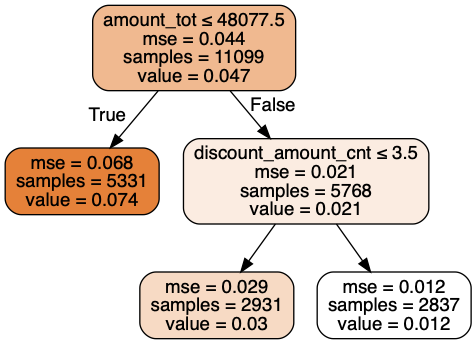

In [23]:
import pydotplus 
from IPython.display import Image
from sklearn.externals.six import StringIO
import os
with open(path + "dt.dot", "w") as f:
    tree.export_graphviz(dtree, out_file=f)
dot_data = StringIO()
tree.export_graphviz(dtree, out_file=dot_data,
                         feature_names=x.columns,
                         class_names=['bad_ind'],
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

value = badrate
将所有的记录根据amount_tot和discount_amount_cnt两个属性分成了3个部分，将用户分成了3类
第一部分有5331，bad_rate为0.074，
第二部分有2931，bad_rate为0.03，
第三部分有2837，bad_rate为0.012

In [24]:
sum(fn.bad_ind)/len(fn.bad_ind)

0.04658077304261645

In [28]:
#模拟上面树的生成策略--
dff1 = fn.loc[(fn.amount_tot>48077.5) & (fn.discount_amount_cnt > 3.5)].copy()
dff1['level'] = 'oil_A'
dff1

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_min,payment_coupon_amount_var_x,payment_coupon_amount_var_y,payment_coupon_amount_var,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc,level
212,A9988361,2018-07-26,2018-08-20,B,0,25,9,9,5502.94,611.437778,...,1.0,0.000000,0.0,1.000000,1,1,1,1,1,oil_A
221,A9960477,2018-07-10,2018-09-21,B,0,73,9,9,1366.50,151.833333,...,0.0,987.654321,100.0,0.011250,1,1,1,1,1,oil_A
232,A9942554,2018-07-31,2018-08-02,B,0,2,27,27,25324.72,937.952593,...,1.0,0.000000,0.0,1.000000,1,1,1,1,1,oil_A
236,A993610,2018-06-15,2018-08-17,B,0,63,5,5,4864.48,972.896000,...,1.0,0.000000,0.0,1.000000,1,1,1,1,2,oil_A
238,A9933539,2018-08-21,2018-08-24,B,0,3,22,22,23705.42,1077.519091,...,1.0,0.000000,0.0,1.000000,1,1,1,1,1,oil_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,A10028522,2018-09-02,2018-09-05,C,0,3,7,7,3352.48,478.925714,...,0.0,35510.204082,500.0,0.006034,1,1,1,1,1,oil_A
11086,A100241,2018-08-09,2018-08-21,C,0,12,12,12,7234.78,602.898333,...,1.0,0.000000,0.0,1.000000,1,1,1,1,1,oil_A
11088,A10019216,2018-07-23,2018-07-30,C,0,7,24,24,15081.82,628.409167,...,1.0,0.000000,0.0,1.000000,1,1,1,1,1,oil_A
11093,A1001592,2018-08-11,2018-09-02,A,0,22,18,18,8495.50,471.972222,...,1.0,0.000000,0.0,1.000000,1,1,1,1,1,oil_A


In [29]:
dff2 = fn.loc[(fn.amount_tot>48077.5) & (fn.discount_amount_cnt <= 3.5)].copy()
dff2['level'] = 'oil_B'
dff2

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_min,payment_coupon_amount_var_x,payment_coupon_amount_var_y,payment_coupon_amount_var,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc,level
89,B96315273747468640,2018-09-13,2018-10-18,D,0,35,1,1,404.36,404.360000,...,300.0,0.000000,0.0,300.000,1,1,1,1,1,oil_B
204,B23429835901074008,2018-10-11,2018-10-15,B,0,4,1,1,198.96,198.960000,...,3000.0,0.000000,0.0,3000.000,1,1,1,1,1,oil_B
214,A9978036,2018-08-29,2018-10-11,A,0,43,1,1,145.10,145.100000,...,0.0,0.000000,0.0,0.000,1,1,1,1,1,oil_B
215,A9973901,2018-07-31,2018-08-02,B,0,2,1,1,1227.78,1227.780000,...,3000.0,0.000000,0.0,3000.000,1,1,1,1,1,oil_B
218,A9964568,2018-10-01,2018-10-12,B,0,11,1,1,261.44,261.440000,...,0.0,0.000000,0.0,0.000,1,1,1,1,1,oil_B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11070,A100650,2018-08-20,2018-09-08,B,0,19,1,1,1519.46,1519.460000,...,0.0,0.000000,0.0,0.000,1,1,1,1,1,oil_B
11073,A1005536,2018-03-22,2018-07-26,B,0,126,2,2,626.46,313.230000,...,500.0,0.000000,0.0,500.000,1,1,1,1,1,oil_B
11074,A1005525,2018-09-27,2018-10-12,B,0,15,3,3,337.38,112.460000,...,0.0,0.000000,0.0,0.000,1,1,1,1,1,oil_B
11081,A10038487,2018-10-03,2018-10-30,C,0,27,1,1,1069.92,1069.920000,...,3400.0,0.000000,0.0,3400.000,1,1,1,1,1,oil_B


In [30]:
dff3 = fn.loc[(fn.amount_tot<=48077.5)].copy()
dff3['level'] = 'oil_C'
dff3

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_min,payment_coupon_amount_var_x,payment_coupon_amount_var_y,payment_coupon_amount_var,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc,level
0,B96436391985035703,2018-10-08,2018-10-08,B,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
1,B96436391984693397,2018-10-11,2018-10-11,E,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
2,B96436391977217468,2018-10-17,2018-10-17,B,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
3,B96436391976480892,2018-09-28,2018-09-28,B,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
4,B96436391972106043,2018-10-19,2018-10-19,A,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,A10017144,2018-10-24,2018-10-24,B,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
11092,A10015929,2018-08-02,2018-08-02,B,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
11094,A1001014,2018-09-02,2018-09-02,B,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C
11096,A1000455,2018-10-06,2018-10-06,B,0,0,1,0,0.00,0.00,...,0.0,0.0,0.0,0.0,1,1,1,1,1,oil_C


In [31]:
type(dff3)

pandas.core.frame.DataFrame

In [32]:
dff1 = dff1.append(dff2)
dff1

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_min,payment_coupon_amount_var_x,payment_coupon_amount_var_y,payment_coupon_amount_var,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc,level
212,A9988361,2018-07-26,2018-08-20,B,0,25,9,9,5502.94,611.437778,...,1.0,0.000000,0.0,1.00000,1,1,1,1,1,oil_A
221,A9960477,2018-07-10,2018-09-21,B,0,73,9,9,1366.50,151.833333,...,0.0,987.654321,100.0,0.01125,1,1,1,1,1,oil_A
232,A9942554,2018-07-31,2018-08-02,B,0,2,27,27,25324.72,937.952593,...,1.0,0.000000,0.0,1.00000,1,1,1,1,1,oil_A
236,A993610,2018-06-15,2018-08-17,B,0,63,5,5,4864.48,972.896000,...,1.0,0.000000,0.0,1.00000,1,1,1,1,2,oil_A
238,A9933539,2018-08-21,2018-08-24,B,0,3,22,22,23705.42,1077.519091,...,1.0,0.000000,0.0,1.00000,1,1,1,1,1,oil_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11070,A100650,2018-08-20,2018-09-08,B,0,19,1,1,1519.46,1519.460000,...,0.0,0.000000,0.0,0.00000,1,1,1,1,1,oil_B
11073,A1005536,2018-03-22,2018-07-26,B,0,126,2,2,626.46,313.230000,...,500.0,0.000000,0.0,500.00000,1,1,1,1,1,oil_B
11074,A1005525,2018-09-27,2018-10-12,B,0,15,3,3,337.38,112.460000,...,0.0,0.000000,0.0,0.00000,1,1,1,1,1,oil_B
11081,A10038487,2018-10-03,2018-10-30,C,0,27,1,1,1069.92,1069.920000,...,3400.0,0.000000,0.0,3400.00000,1,1,1,1,1,oil_B


In [33]:
dff1 = dff1.append(dff3)
dff1.shape

(11099, 75)

In [37]:
last = dff1[['class_new','level','bad_ind','uid','oil_actv_dt','bad_ind']].copy()  #只取dataframe中的部分列
last['oil_actv_dt'] = last['oil_actv_dt'] .apply(lambda x:str(x)[:7]).copy()
last   #给每个用户打了一个级别

,class_new,level,bad_ind,uid,oil_actv_dt,bad_ind
212,B,oil_A,0,A9988361,2018-08,0
221,B,oil_A,0,A9960477,2018-09,0
232,B,oil_A,0,A9942554,2018-08,0
236,B,oil_A,0,A993610,2018-08,0
238,B,oil_A,0,A9933539,2018-08,0
...,...,...,...,...,...,...
11091,B,oil_C,0,A10017144,2018-10,0
11092,B,oil_C,0,A10015929,2018-08,0
11094,B,oil_C,0,A1001014,2018-09,0
11096,B,oil_C,0,A1000455,2018-10,0


In [41]:
last.to_excel(path+'final_report.xlsx',index=False)